In [1]:
# Movie Reviews

In [3]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [5]:
# Function for feature building and extraction on natural language data

In [6]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, stop_words={'crazy'}, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
#     X_quant_features = movie_data[["word_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [7]:
# Create Training Data

In [8]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./data/moviereviews_train.tsv', my_random_seed=13)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


In [9]:
# Fit Various models
# Ordinary least squares model

In [10]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 4986, 'TN': 5180, 'FP': 4818, 'FN': 5016, 'Accuracy': 0.5083, 'Precision': 0.5085679314565483, 'Recall': 0.498500299940012, 'desc': 'ols_train'}


In [7]:
# Model SVM, linear

In [11]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


In [15]:
# SVC
from sklearn import svm
# Default
svm_svc = svm.LinearSVC()
svm_svc.fit(X_train, y_train)

svm_svc_performance_train = BinaryClassificationPerformance(svm_svc.predict(X_train), y_train, 'svm_svc_train')
svm_svc_performance_train.compute_measures()
print(svm_svc_performance_train.performance_measures)

# c=100
svm_svc_100 = svm.LinearSVC(C=100)
svm_svc_100.fit(X_train, y_train)

svm_svc_performance_train_100 = BinaryClassificationPerformance(svm_svc_100.predict(X_train), y_train, 'svm_svc_train_100')
svm_svc_performance_train_100.compute_measures()
print(svm_svc_performance_train_100.performance_measures)

# c=.1
svm_svc_1 = svm.LinearSVC(C=.1)
svm_svc_1.fit(X_train, y_train)

svm_svc_performance_train_1 = BinaryClassificationPerformance(svm_svc_1.predict(X_train), y_train, 'svm_svc_train_1')
svm_svc_performance_train_1.compute_measures()
print(svm_svc_performance_train_1.performance_measures)

# c=.0001
svm_svc_0001 = svm.LinearSVC(C=.0001)
svm_svc_0001.fit(X_train, y_train)

svm_svc_performance_train_0001 = BinaryClassificationPerformance(svm_svc_0001.predict(X_train), y_train, 'svm_svc_train_0001')
svm_svc_performance_train_0001.compute_measures()
print(svm_svc_performance_train_0001.performance_measures)

# c=.000001
svm_svc_000001 = svm.LinearSVC(C=.000001)
svm_svc_000001.fit(X_train, y_train)

svm_svc_performance_train_000001 = BinaryClassificationPerformance(svm_svc_000001.predict(X_train), y_train, 'svm_svc_train_000001')
svm_svc_performance_train_000001.compute_measures()
print(svm_svc_performance_train_000001.performance_measures)

# c=.00000001
svm_svc_00000001 = svm.LinearSVC(C=.00000001)
svm_svc_00000001.fit(X_train, y_train)

svm_svc_performance_train_00000001 = BinaryClassificationPerformance(svm_svc_00000001.predict(X_train), y_train, 'svm_svc_train_00000001')
svm_svc_performance_train_00000001.compute_measures()
print(svm_svc_performance_train_00000001.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_svc_train'}
{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_svc_train_100'}
{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_svc_train_1'}
{'Pos': 10002, 'Neg': 9998, 'TP': 10001, 'TN': 9998, 'FP': 0, 'FN': 1, 'Accuracy': 0.99995, 'Precision': 1.0, 'Recall': 0.9999000199960008, 'desc': 'svm_svc_train_0001'}
{'Pos': 10002, 'Neg': 9998, 'TP': 9522, 'TN': 9759, 'FP': 239, 'FN': 480, 'Accuracy': 0.96405, 'Precision': 0.9755148038110849, 'Recall': 0.9520095980803839, 'desc': 'svm_svc_train_000001'}
{'Pos': 10002, 'Neg': 9998, 'TP': 8728, 'TN': 9759, 'FP': 239, 'FN': 1274, 'Accuracy': 0.92435, 'Precision': 0.9733467157354745, 'Recall': 0.872625474905019, 'desc': 'svm_svc_train_00000001'}


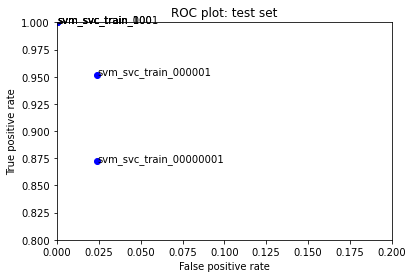

In [16]:
fits = [svm_svc_performance_train, svm_svc_performance_train_100, svm_svc_performance_train_1, svm_svc_performance_train_0001, svm_svc_performance_train_000001, svm_svc_performance_train_00000001]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .2, .8, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [17]:
# default
svm_svc_performance_test = BinaryClassificationPerformance(svm_svc.predict(X_test), y_test, 'svm_svc_test')
svm_svc_performance_test.compute_measures()
print(svm_svc_performance_test.performance_measures)

# 100
svm_svc_performance_test_100 = BinaryClassificationPerformance(svm_svc_100.predict(X_test), y_test, 'svm_svc_test_100')
svm_svc_performance_test_100.compute_measures()
print(svm_svc_performance_test_100.performance_measures)

# .1
svm_svc_performance_test_1 = BinaryClassificationPerformance(svm_svc_1.predict(X_test), y_test, 'svm_svc_test_1')
svm_svc_performance_test_1.compute_measures()
print(svm_svc_performance_test_1.performance_measures)

# .0001
svm_svc_performance_test_0001 = BinaryClassificationPerformance(svm_svc_0001.predict(X_test), y_test, 'svm_svc_test_0001')
svm_svc_performance_test_0001.compute_measures()
print(svm_svc_performance_test_0001.performance_measures)

# .000001
svm_svc_performance_test_000001 = BinaryClassificationPerformance(svm_svc_000001.predict(X_test), y_test, 'svm_svc_test_000001')
svm_svc_performance_test_000001.compute_measures()
print(svm_svc_performance_test_000001.performance_measures)

# .00000001
svm_svc_performance_test_00000001 = BinaryClassificationPerformance(svm_svc_00000001.predict(X_test), y_test, 'svm_svc_test_00000001')
svm_svc_performance_test_00000001.compute_measures()
print(svm_svc_performance_test_00000001.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2162, 'TN': 2120, 'FP': 382, 'FN': 336, 'Accuracy': 0.8564, 'Precision': 0.8498427672955975, 'Recall': 0.8654923939151321, 'desc': 'svm_svc_test'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2162, 'TN': 2120, 'FP': 382, 'FN': 336, 'Accuracy': 0.8564, 'Precision': 0.8498427672955975, 'Recall': 0.8654923939151321, 'desc': 'svm_svc_test_100'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2162, 'TN': 2120, 'FP': 382, 'FN': 336, 'Accuracy': 0.8564, 'Precision': 0.8498427672955975, 'Recall': 0.8654923939151321, 'desc': 'svm_svc_test_1'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2186, 'TN': 2163, 'FP': 339, 'FN': 312, 'Accuracy': 0.8698, 'Precision': 0.8657425742574257, 'Recall': 0.8751000800640513, 'desc': 'svm_svc_test_0001'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2145, 'TN': 2223, 'FP': 279, 'FN': 353, 'Accuracy': 0.8736, 'Precision': 0.8849009900990099, 'Recall': 0.8586869495596477, 'desc': 'svm_svc_test_000001'}
{'Pos': 2498, 'Neg': 2502, 'TP': 1902, 'TN': 2313, 'FP': 189, 'FN': 596, 'Accuracy

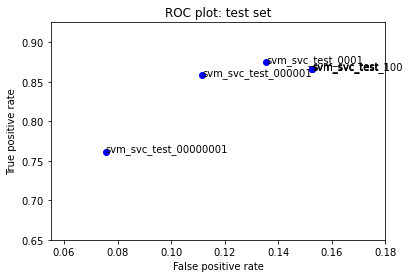

In [18]:
fits = [svm_svc_performance_test, svm_svc_performance_test_100, svm_svc_performance_test_1, svm_svc_performance_test_0001, svm_svc_performance_test_000001, svm_svc_performance_test_00000001]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.055, .18, 0.65, .925])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [19]:
# Model Logistic regression

In [20]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


In [21]:
# Model Maive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 9586, 'TN': 9832, 'FP': 166, 'FN': 416, 'Accuracy': 0.9709, 'Precision': 0.9829778506972928, 'Recall': 0.9584083183363328, 'desc': 'nbs_train'}


In [23]:
# Model Perceptron

In [24]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


In [25]:
# Model Ridge Regression Classifier

In [26]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=500000)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 9591, 'TN': 9694, 'FP': 304, 'FN': 411, 'Accuracy': 0.96425, 'Precision': 0.969277412834765, 'Recall': 0.9589082183563288, 'desc': 'rdg_train'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2192, 'TN': 2177, 'FP': 325, 'FN': 306, 'Accuracy': 0.8738, 'Precision': 0.8708780294000794, 'Recall': 0.877502001601281, 'desc': 'rdg_test'}


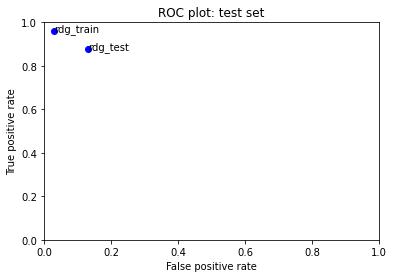

In [27]:
fits = [rdg_performance_train, rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [28]:
# model random forest classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 8298, 'TN': 7161, 'FP': 2837, 'FN': 1704, 'Accuracy': 0.77295, 'Precision': 0.7452177817691962, 'Recall': 0.829634073185363, 'desc': 'rdf_train'}


In [30]:
# ROC plor to compare performance of various models and fits

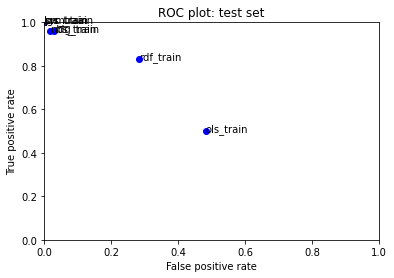

In [31]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

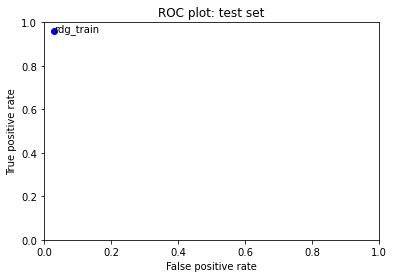

In [32]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [33]:
# Looking at reviews based on their classification

In [34]:
ols_predictions = ols.predict(X_train)

In [35]:
# False positives

In [36]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')

Examples of false positives:
12
Watching this movie was the biggest waste of time and 2 bucks for rental in my life. If nothing catastrophic happens before I die, this will be the biggest regret of my life. Who ever even thought about this movie, or financed deserves a kick between the legs, because that's where they were thinking when they made this movie. It's about an overweight guy who is a hopeless romantic, and writes pretentious drivel that tries to pass off as poetry. He joins his amorous friend in a trip to the coast. Where they meet girls and such. Only the fat guy doesn't get a girl. Skin flicks don't annoy me, I take 'em for face value. But this movie tries to be more than a skin flick. It's about Fat guy looking for love in some girl, but then meets another bikini silicone girl that enjoys his poetry. He finds his talent for volleyball which gets money for his family and impresses the ladies, only he has his lady anyways. The dialogue is super-horrible for even a C movie. 

3694
Totally forgettable. Specially because of the weak acting. This is the first movie I've seen with Dax Shepard. To my surprise, he's been around since the late 90's. I thought he was a newcomer, since his acting was so bland. I could say the same about Liv Tyler. Although I've seen her do well in other movies, she gave Clare Cooper a strange personality. Liv is not the kind of actress that will give the character a fiery, emotional personality like Diane Keaton would be able to, but it was pretty strange to see her say her lines in whisper mode. It seemed that altogether there simply wasn't a very good chemistry going on between the actors, and I think Diane Keaton sensed that as well. She's a fantastic actress, but seemed just a bit over the top in this movie. It felt like she just wanted to get this movie over as soon as possible. I wouldn't blame her.
* * * * * * * * * 
3910
Stanley Kramer directs an action thriller and leaves out two key things: action and thrills. THE DOMINO P

7592
\Igor and the Lunatics\" is a totally inept and amateurish attempt at a crazy-hippie-cult-killing-spree horror movie. Apparently even nearly twenty years later, Charles Manson was still inspiring overenthusiastic but incompetent trash-filmmakers. This is a typical Troma production, meaning in other words, there's a lot of boring and totally irrelevant padding footage to accompany the nonsensical plot. There's a bit of random gore and gratuitous nudity on display  which isn't bad  but it's all so very pointless and ugly that it becomes frustrating to look at. \"Igor and the Lunatics\" is so desperate that it's even using a lot of the footage twice, like the circle saw killing for example. The incoherent plot tries to tell the story of a hippie cult run by the drug-addicted and Charlie Manson wannabe Paul. One of Paul's lower ranked disciples, named Igor, becomes a little bit too obsessed with the Bible stories and drug orgies and gradually causes the entire cult to descent furthe

11396
This must be one of the worst Swedish movies ever made. <br /><br />It is embarrassing that such a bad script was allowed to become a movie and shown in cinemas as recently as year 2006.<br /><br />I've never seen so many visible sponsored products in one and the same movie. It shouldn't be that obvious. <br /><br />I can't understand why so many known actors even thought the idea to even be visible in a movie like this. If I had any respect for some of the known actors in this movie before I saw the movie, it is gone for sure now. <br /><br />I've heard that there will be a follow up movie to this one and I can't understand how that is even possible.
* * * * * * * * * 
11498
Admittedly, I didn't have high expectations of \Corky Romano.\" But then again, who did? However, I felt it deserved the benefit of the doubt. I had no high hopes of \"Joe Dirt\" either--another recent comedy starring an SNL cast member--and I ended up being pleasantly surprised. But this film is just as bad

15060
And I thought The Beach was bad, with the difference that this movie has one of the greatest actors of our time, Nicolas Cage. Don't blame him for the awful script, if any one can make any sense of what the hell was the point of that movie, give your self a pat on the back. Its a cross between The Village and a crappier script. Its starts off kinda catching your eye, and then as it goes further into the plot, it just makes no sense, and don't get me started about the ending!!!! What was that? The only thing that makes this movie exist is Nicolas Cage usual great humor, and his ability to be funny in the weirdest situations. If you go to a blockbuster and this is the only movie to watch, save yourself five bucks and just go back home and turn put some thing on fire and when some ones asks you why, just say the stupidest thing that comes into your mind, and there you go!
* * * * * * * * * 
15164
This has got to be the worst horror movie I have ever seen. I remember watching it year

18474
This movie is one of the most wildly distorted portrayals of history. Horribly inaccurate, this movie does nothing to honor the hundreds of thousands of Dutch, British, Chinese, American and indigenous enslaved laborers that the sadistic Japanese killed and tortured to death. The bridge was to be built \over the bodies of the white man\" as stated by the head Japanese engineer. It is disgusting that such unspeakable horrors committed by the Japanese captors is the source of a movie, where the bridge itself, isn't even close to accurate to the actual bridge. The actual bridge was built of steel and concrete, not wood. What of the survivors who are still alive today? They hate the movie and all that it is supposed to represent. Their friends were starved, tortured, and murdered by cruel sadists. Those that didn't die of dysantry, starvation, or disease are deeply hurt by the movie that makes such light of their dark times."
* * * * * * * * * 
18785
I couldn't bear to sit through he

In [37]:
# Look at performace on the test set
# Model ordinary least squares

In [38]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)


{'Pos': 2498, 'Neg': 2502, 'TP': 1178, 'TN': 1282, 'FP': 1220, 'FN': 1320, 'Accuracy': 0.492, 'Precision': 0.49124270225187655, 'Recall': 0.47157726180944753, 'desc': 'ols_test'}


In [39]:
# Model SVM linear

In [40]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

AttributeError: module 'sklearn.svm' has no attribute 'predict'

In [41]:
# Model logistic regression

In [42]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2078, 'TN': 2071, 'FP': 431, 'FN': 420, 'Accuracy': 0.8298, 'Precision': 0.8282184137106416, 'Recall': 0.8318654923939152, 'desc': 'lgs_test'}


In [43]:
# Model naive Bayes

In [44]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 1802, 'TN': 1880, 'FP': 622, 'FN': 696, 'Accuracy': 0.7364, 'Precision': 0.7433993399339934, 'Recall': 0.7213771016813451, 'desc': 'nbs_test'}


In [45]:
# Model precertron

In [46]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2078, 'TN': 2056, 'FP': 446, 'FN': 420, 'Accuracy': 0.8268, 'Precision': 0.8232963549920761, 'Recall': 0.8318654923939152, 'desc': 'prc_test'}


In [47]:
# Model Ridge regression classifier

In [48]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2192, 'TN': 2177, 'FP': 325, 'FN': 306, 'Accuracy': 0.8738, 'Precision': 0.8708780294000794, 'Recall': 0.877502001601281, 'desc': 'rdg_test'}


In [49]:
# Random Forest classifier

In [50]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2044, 'TN': 1783, 'FP': 719, 'FN': 454, 'Accuracy': 0.7654, 'Precision': 0.7397756062251176, 'Recall': 0.8182546036829463, 'desc': 'rdf_test'}


In [51]:
# ROC plot to compare performance of various models and fits

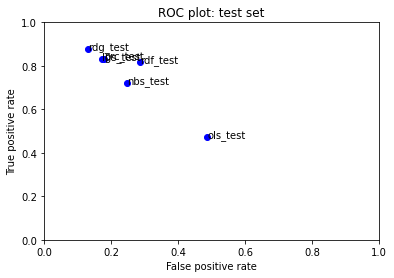

In [64]:
fits = [ols_performance_test, lgs_performance_test, nbs_performance_test, rdg_performance_test,prc_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

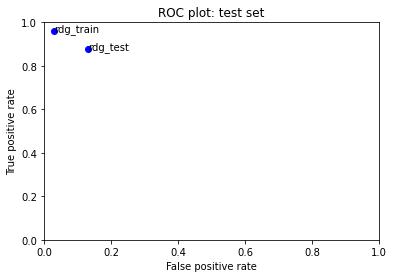

In [65]:
fits = [rdg_performance_train, rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Test Submission

In [66]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./data/moviereviews_train.tsv', my_random_seed=13, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5          89           5
6         112           9
7 

In [88]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["rdg"] = rdg.predict(X_test_submission)
my_submission["lgs"] = lgs.predict(X_test_submission)
my_submission["rdf"] = rdf.predict(X_test_submission)
my_submission["nbs"] = nbs.predict(X_test_submission)
my_submission["prc"] = prc.predict(X_test_submission)
my_submission["total"] = my_submission["rdg"] + my_submission["lgs"] + my_submission["rdf"] + my_submission["nbs"] + my_submission["prc"]

my_submission["prediction"] = np.where(my_submission["total"]>2, 1, 0)
# look at the proportion of positive predictions
# print(my_submission['prediction'].mean())

In [89]:
my_submission.head(50)

,id,rdg,lgs,rdf,nbs,prc,total,prediction
0,5814_8,1,1,0,1,1,4,1
1,2381_9,1,1,1,1,1,5,1
2,7759_3,0,0,1,0,0,1,0
3,3630_4,0,0,1,1,0,2,0
4,9495_8,1,1,1,1,1,5,1
5,8196_8,1,1,0,1,1,4,1
6,7166_2,0,0,0,0,0,0,0
7,10633_1,0,0,0,0,0,0,0
8,319_1,0,0,1,0,0,1,0
9,8713_10,1,1,1,1,1,5,1


In [85]:
my_submission.shape

(25000, 8)

In [86]:
my_submission.drop("rdg", axis=1, inplace=True)
my_submission.drop("lgs", axis=1, inplace=True)
my_submission.drop("rdf", axis=1, inplace=True)
my_submission.drop("nbs", axis=1, inplace=True)
my_submission.drop("prc", axis=1, inplace=True)
my_submission.drop("total", axis=1, inplace=True)
my_submission.head()

,id,prediction
0,5814_8,1
1,2381_9,1
2,7759_3,0
3,3630_4,0
4,9495_8,1


In [87]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('juliet_assignment1_FINALiteration_moviereviews_submission.csv', index=False)